| train_loss: 1.01e-01 | test_loss: 1.19e-01 | reg: 1.23e+01 | : 100%|█| 20/20 [00:08<00:00,  2.38it


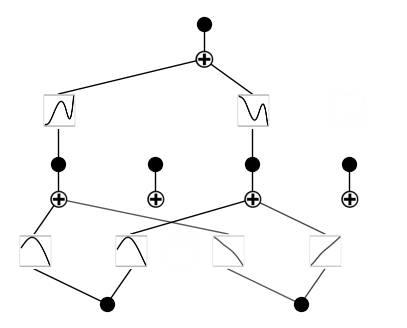

In [7]:
import torch
from kan import create_dataset
from kan.custom import MultKAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.sin(2 * x[:, [0]]) * x[:, [1]]
dataset = create_dataset(f,
                         ranges=[-torch.pi, torch.pi],
                         n_var=2,
                         train_num=3000,
                         test_num=300,
                         device=device,
                         normalize_label=True,
                         normalize_input=True,
                         )

model = MultKAN(width=[2,4,1], grid=3, k=3, seed=0, device=device)
fit_kwargs = {'opt': 'LBFGS', 'lr': 1, 'lamb': 0.01,
              'lamb_entropy': 0.1, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5,}
model.fit(dataset, steps=20, **fit_kwargs)
model.plot()

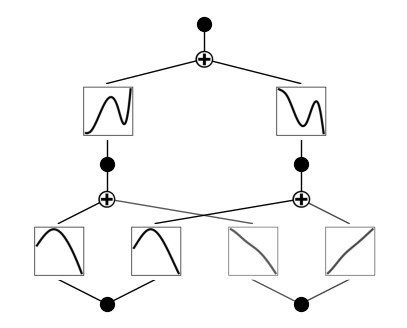

In [8]:
model = model.prune(edge_th=0.05, node_th=0.05)
model.plot()

In [9]:
grids = [3, 5, 10, 20, 30]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = model.refine(grids[i])
    results = model.fit(dataset, steps=50, stop_grid_update_step=20, **fit_kwargs)
    model = model.prune(edge_th=3e-2, node_th=1e-2)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

| train_loss: 7.09e-02 | test_loss: 7.57e-02 | reg: 1.21e+01 | : 100%|█| 50/50 [00:18<00:00,  2.73it
| train_loss: 7.02e-02 | test_loss: 8.33e-02 | reg: 6.13e+00 | : 100%|█| 50/50 [00:17<00:00,  2.81it
| train_loss: 4.65e-02 | test_loss: 5.30e-02 | reg: 5.71e+00 | : 100%|█| 50/50 [00:18<00:00,  2.70it
| train_loss: 4.24e-02 | test_loss: 5.12e-02 | reg: 5.62e+00 | : 100%|█| 50/50 [00:17<00:00,  2.88it
| train_loss: 3.97e-02 | test_loss: 4.81e-02 | reg: 5.08e+00 | : 100%|█| 50/50 [00:18<00:00,  2.74it


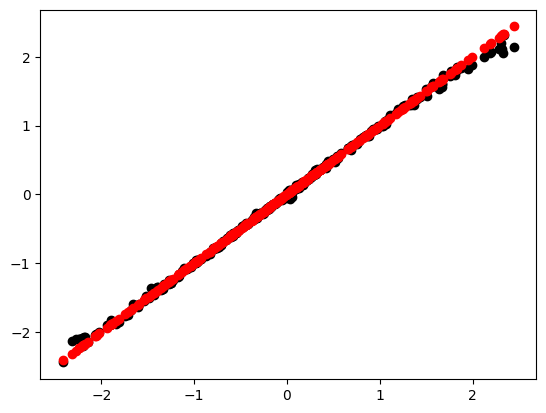

In [10]:
import matplotlib.pyplot as plt
y_pred = model(dataset['test_input']).detach().cpu().numpy()
plt.scatter(dataset['test_label'], y_pred, color='k')
plt.scatter(dataset['test_label'], dataset['test_label'], color='r')
plt.show()

tensor([[ 0.0719],
        [-0.0026],
        [-1.3765],
        ...,
        [ 0.4839],
        [-1.3662],
        [ 0.1490]], grad_fn=<AddBackward0>)

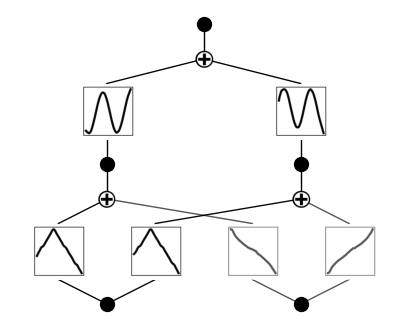

In [11]:
model.plot()
model.forward(dataset['train_input'])

In [48]:
# torch.save(model.state_dict(), f"toy_5_refining_grid_model.pt")

In [49]:
# model_test = model

# model_test = MultKAN(width=[2,2,1], grid=grids[-1], k=3, seed=0, device=device)
# model_test.load_state_dict(torch.load(f"toy_5_refining_grid_model.pt"))
# model_test.forward(dataset['train_input'])
# model_test.plot()

In [50]:
# model_test.fit(dataset, steps=1)

In [51]:
# model_test.suggest_symbolic(0,0,0, weight_simple=0.5)

In [12]:
model.auto_symbolic(weight_simple=0.5)
model.forward(dataset['train_input'])

r2 is 0.9984312653541565
fixing (0,0,0) with abs, r2=1.0, c=3
r2 is 0.9982811808586121
fixing (0,0,1) with abs, r2=1.0, c=3
r2 is 0.9985458850860596
fixing (0,1,0) with tan, r2=1.0, c=3
r2 is 0.9986410140991211
fixing (0,1,1) with tan, r2=1.0, c=3
r2 is 0.9987587928771973
fixing (1,0,0) with sin, r2=1.0, c=2
r2 is 0.9991302490234375
fixing (1,1,0) with cos, r2=1.0, c=2


RuntimeError: stack expects each tensor to be equal size, but got [2, 3000, 1] at entry 0 and [2] at entry 1

In [ ]:
from kan.utils import ex_round
model.auto_symbolic(weight_simple=0.5)
fit_kwargs_sym = {'opt': 'LBFGS', 'lr': 1, 'lamb': 0.01,
                  'lamb_entropy': 0.1, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5,}
fit_kwargs_sym['update_grid'] = False
res = model.fit(dataset, steps=50, **fit_kwargs_sym)
print(res['test_loss'][-1])

In [55]:
model.plot()

cannot plot since data are not saved. Set save_act=True first.


IndexError: list index out of range

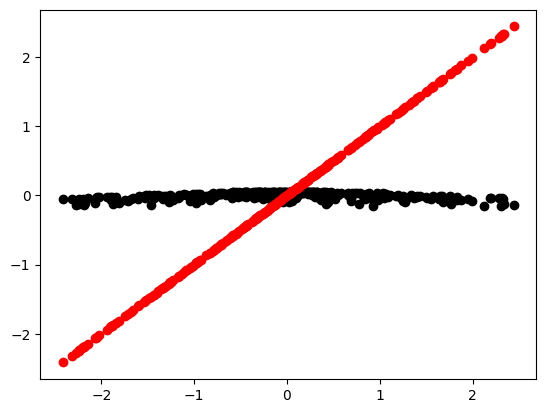

In [49]:
y_pred = model(dataset['test_input']).detach().cpu().numpy()
plt.scatter(dataset['test_label'], y_pred, color='k')
plt.scatter(dataset['test_label'], dataset['test_label'], color='r')
plt.show()